# Лабораторна робота 3. Побудова автокодувальника

Розробити звичайний автокодувальник  для датасету рукописних цифр MNIST на основі багатошарової нейронної мережі.  

Розробити звичайний автокодувальник для датасету MNIST на основі згорткової моделі. 
В обох випадках розробити власну архітектуру, підібрати кількість шарів, нейронів, функцію активації. Побудувати графіки функції втрат. Результати розпізнавання! 
Зробити висновки! 

In [5]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


# Імпортуємо бібліотеки

Ініціалізую середовище для роботи з нейронними мережами в PyTorch, бібліотекою для машинного навчання. Спершу імпортуються необхідні модулі, зокрема torch, torch.nn для побудови нейронних мереж, Variable для роботи з автоматичним диференціюванням, Data для обробки даних, torchvision для роботи з зображеннями, matplotlib.pyplot з mpl_toolkits.mplot3d для візуалізації, cm для кольорових мап і numpy. Потім викликається %matplotlib inline для відображення графіків у Jupyter Notebook. Нарешті, фіксується генератор випадкових чисел за допомогою torch.manual_seed(1), що забезпечує відтворюваність результатів.

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

torch.manual_seed(1)    

Задаємо гіперпараметри для процесу тренування нейронної мережі. EPOCH = 10 означає, що навчальний набір даних буде проходити через мережу десять разів. BATCH_SIZE = 64 визначає розмір пакета даних, тобто 64 зразки будуть оброблятися одночасно під час тренування. LR = 0.005 встановлює швидкість навчання, яка керує величиною корекції ваг нейронної мережі на кожному кроці тренування. DOWNLOAD_MNIST = False говорить, що немає потреби знову завантажувати набір даних MNIST, припускаючи, що він вже доступний локально. N_TEST_IMG = 5 вказує на кількість зображень, які будуть використовуватися для тестування мережі під час тренування, у цьому випадку – п'ять.

In [39]:
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # швидкість навчання
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [40]:
import torchvision
import os

# Створення каталогу в домашній папці для набору даних
home_dir = os.path.expanduser("~")
dataset_dir = os.path.join(home_dir, "mnist_dataset")

DOWNLOAD_MNIST = True  

train_data = torchvision.datasets.MNIST(
    root=dataset_dir,  
    train=True,        
    transform=torchvision.transforms.ToTensor(),  
    download=DOWNLOAD_MNIST,        
)


torch.Size([60000, 28, 28])
torch.Size([60000])


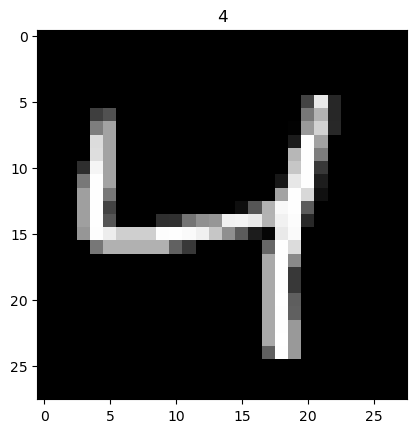

In [42]:
# побудувати один приклад
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [15]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.2305


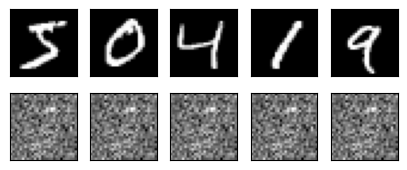

Epoch:  0 | train loss: 0.0624


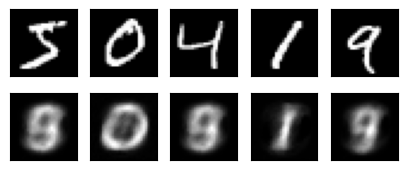

Epoch:  5 | train loss: 0.0374


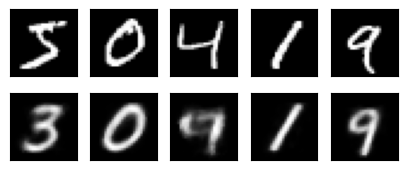

Epoch:  5 | train loss: 0.0346


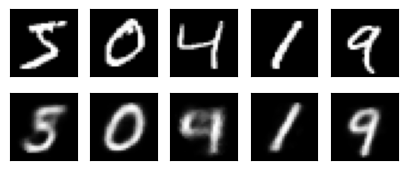

Epoch:  9 | train loss: 0.0341


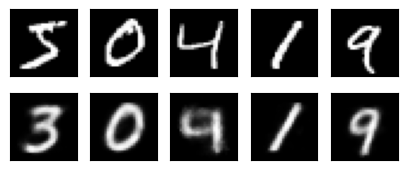

Epoch:  9 | train loss: 0.0340


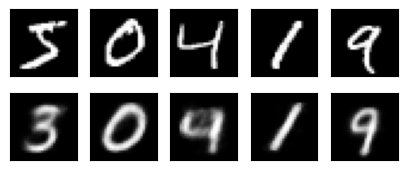

In [37]:
autoencoder = AutoEncoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()
loss_values = []

# вихідні дані (перший рядок) для перегляду
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   
        b_y = Variable(x.view(-1, 28*28))   
        b_label = Variable(y)               

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()                    

        loss_values.append(loss.data.item())

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())


            # креслення декодованого зображення (другий ряд)
            _, decoded_data = autoencoder(view_data)
            
            # ініціалізувати малюнок
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)

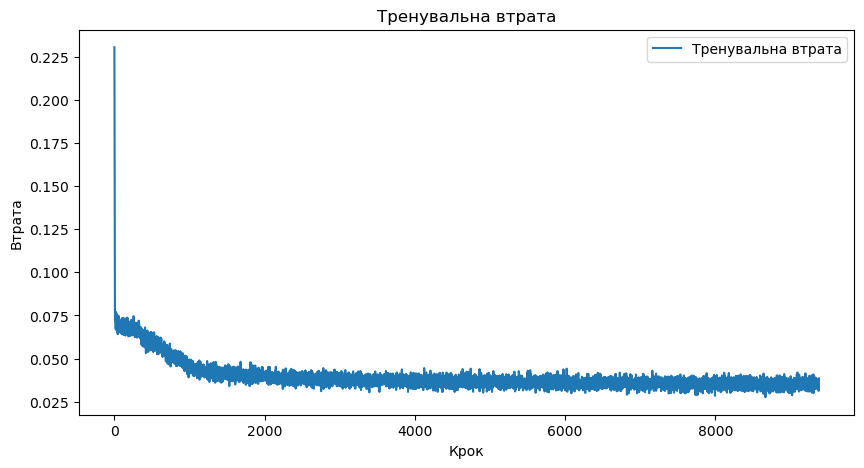

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Тренувальна втрата')
plt.title('Тренувальна втрата')
plt.xlabel('Крок')
plt.ylabel('Втрата')
plt.legend()
plt.show()

In [44]:
# Визначаємо архітектуру згорткового автокодувальника
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = ConvAutoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [45]:
# Функція для візуалізації зображень
def plot_images(imgs, decoded_imgs, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Оригінальні зображення
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Відновлені зображення
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


Epoch:  0 | train loss: 0.2018


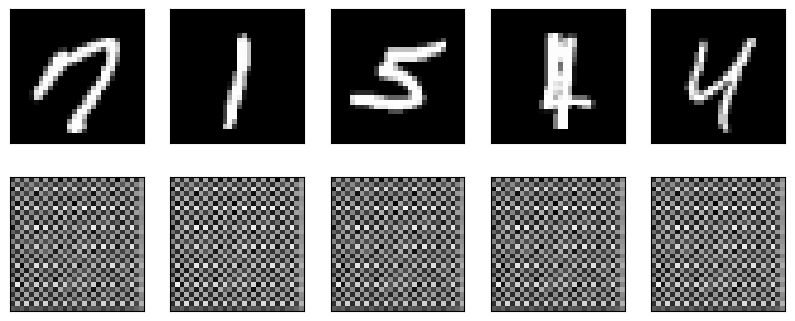

Epoch:  0 | train loss: 0.0062


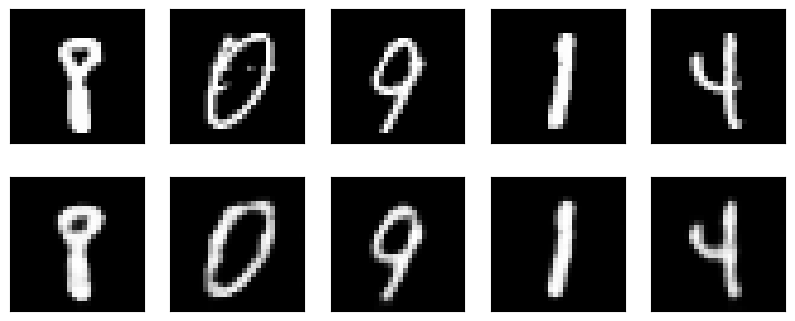

Epoch:  1 | train loss: 0.0048


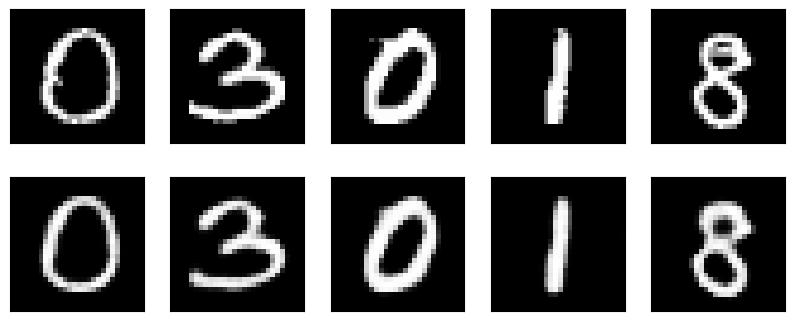

Epoch:  1 | train loss: 0.0037


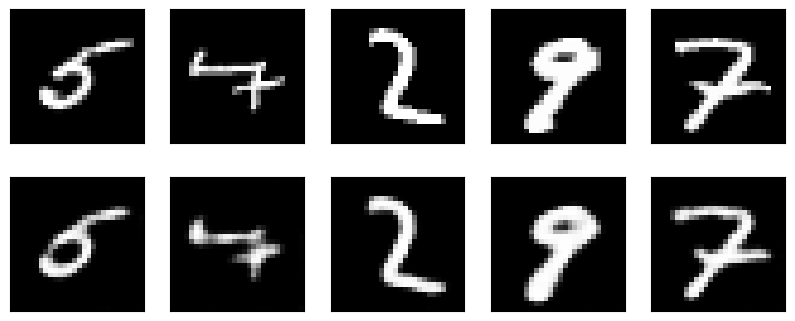

Epoch:  2 | train loss: 0.0034


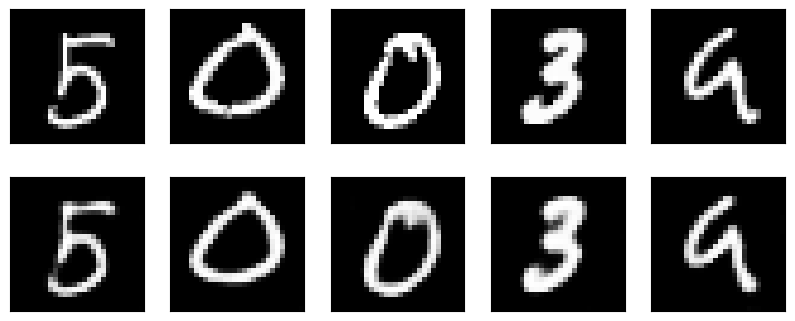

Epoch:  2 | train loss: 0.0027


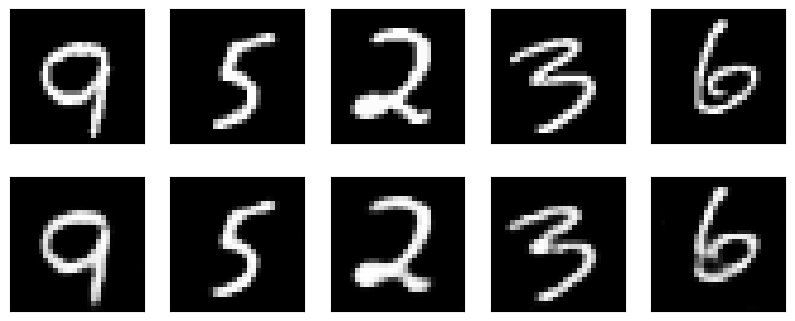

Epoch:  3 | train loss: 0.0031


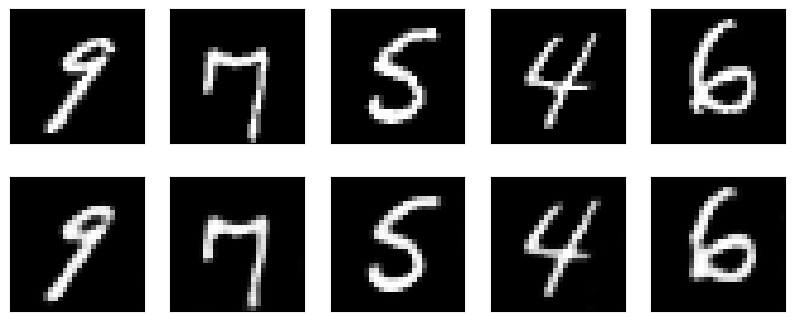

Epoch:  3 | train loss: 0.0025


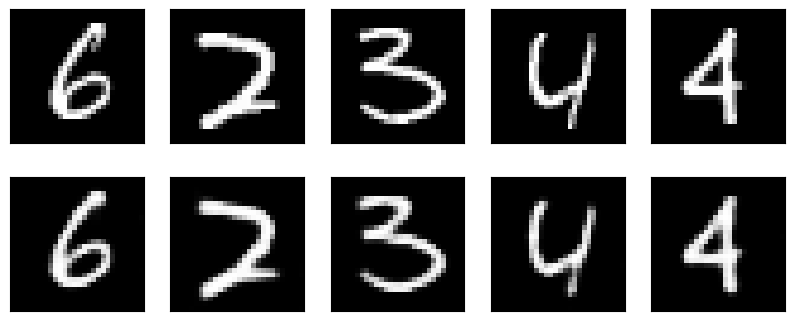

Epoch:  4 | train loss: 0.0025


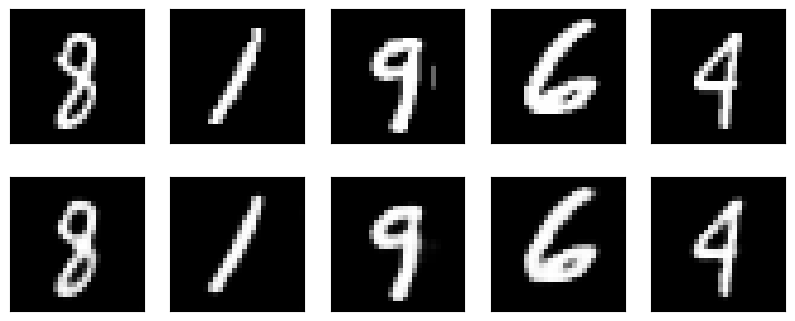

Epoch:  4 | train loss: 0.0026


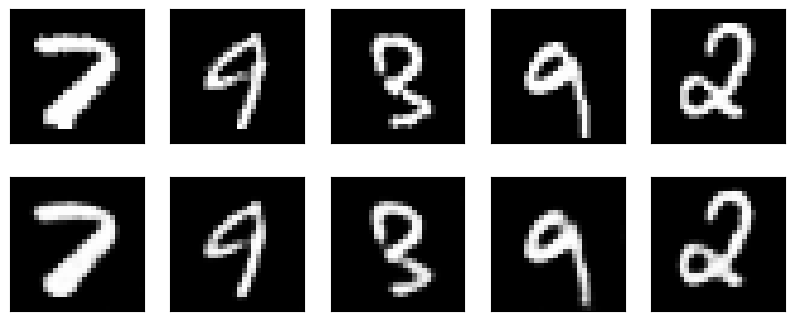

Epoch:  5 | train loss: 0.0028


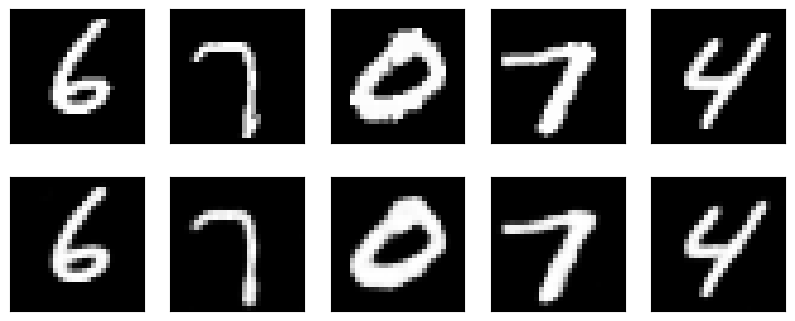

Epoch:  5 | train loss: 0.0027


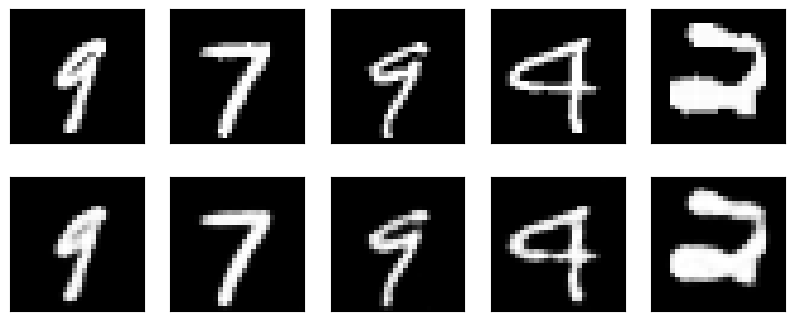

Epoch:  6 | train loss: 0.0024


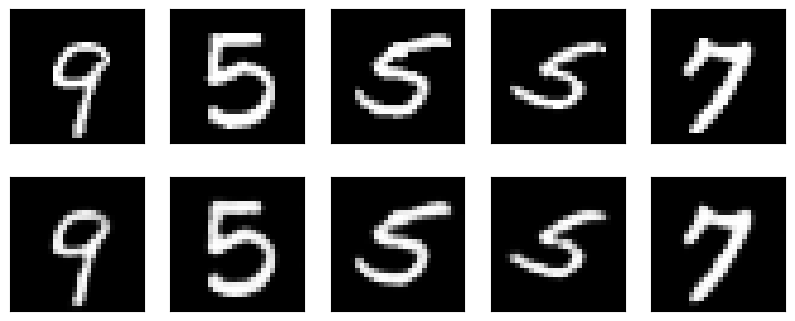

Epoch:  6 | train loss: 0.0029


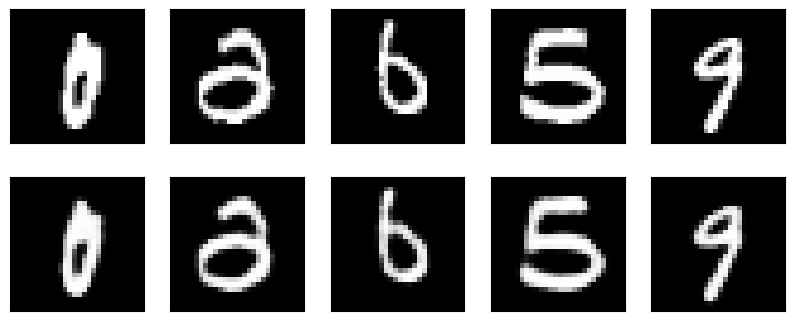

Epoch:  7 | train loss: 0.0025


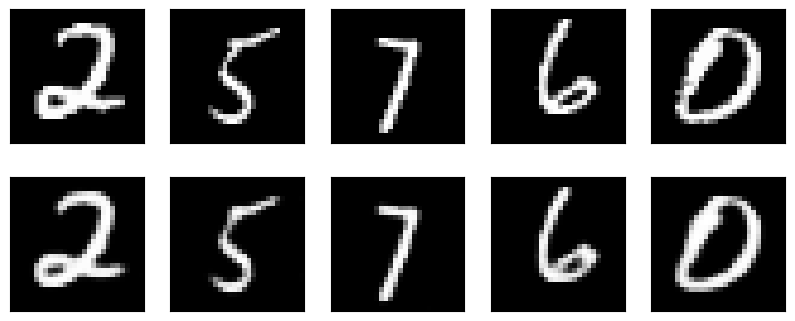

Epoch:  7 | train loss: 0.0025


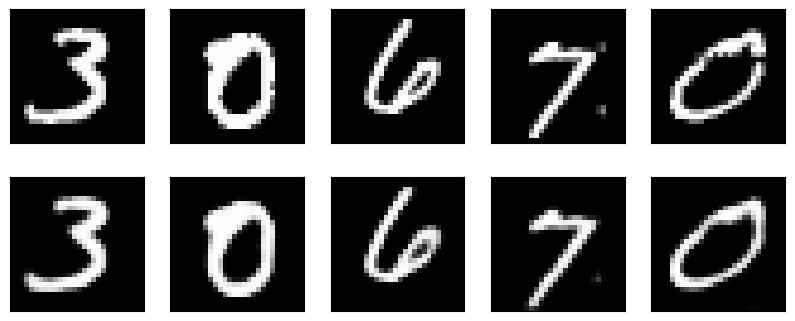

Epoch:  8 | train loss: 0.0023


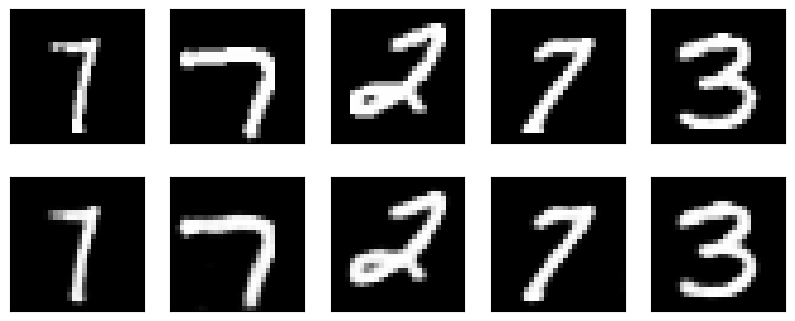

Epoch:  8 | train loss: 0.0022


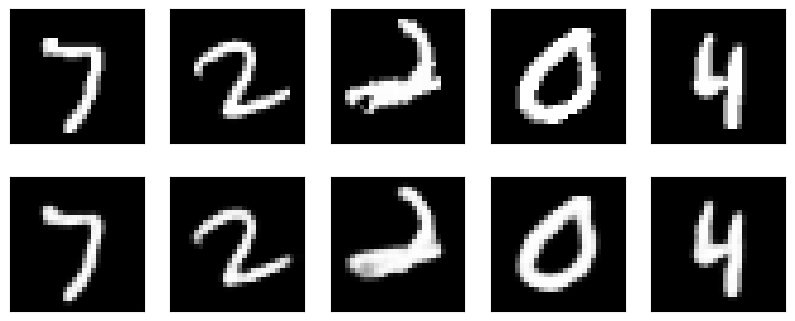

Epoch:  9 | train loss: 0.0023


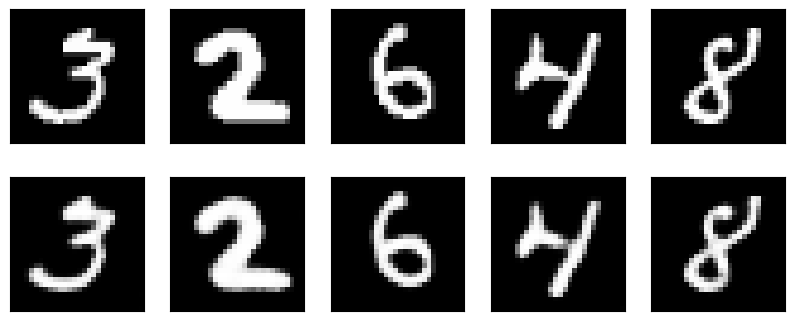

Epoch:  9 | train loss: 0.0023


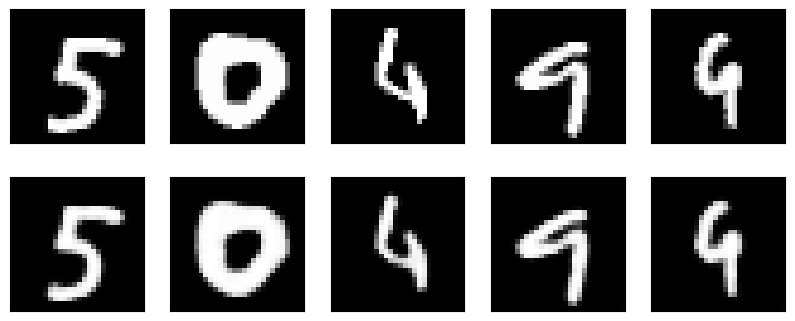

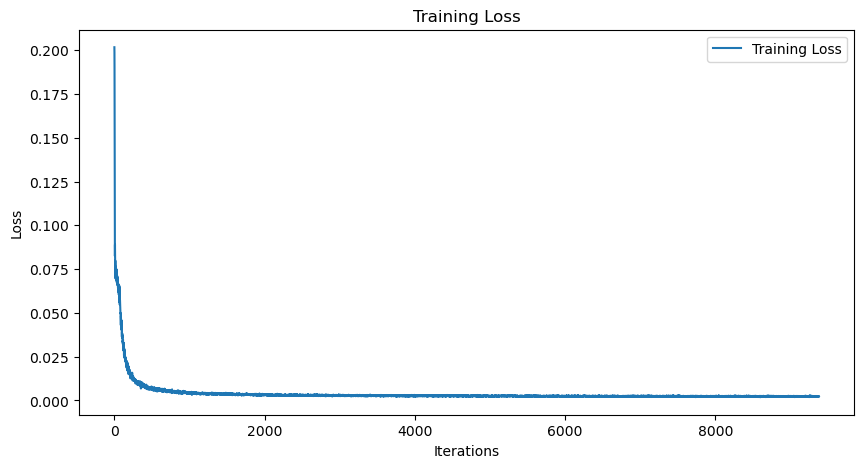

In [46]:
# Ініціалізація списку для збереження втрат
losses = []

for epoch in range(EPOCH):
    for step, (x, _) in enumerate(train_loader):
        b_x = x  # отримуємо зображення
        b_y = x  # мітка - те ж зображення

        output = autoencoder(b_x)
        loss = loss_func(output, b_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if step % 500 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
            # Візуалізація відновлених зображень
            decoded_imgs = autoencoder(b_x[:N_TEST_IMG])
            plot_images(b_x, decoded_imgs, N_TEST_IMG)


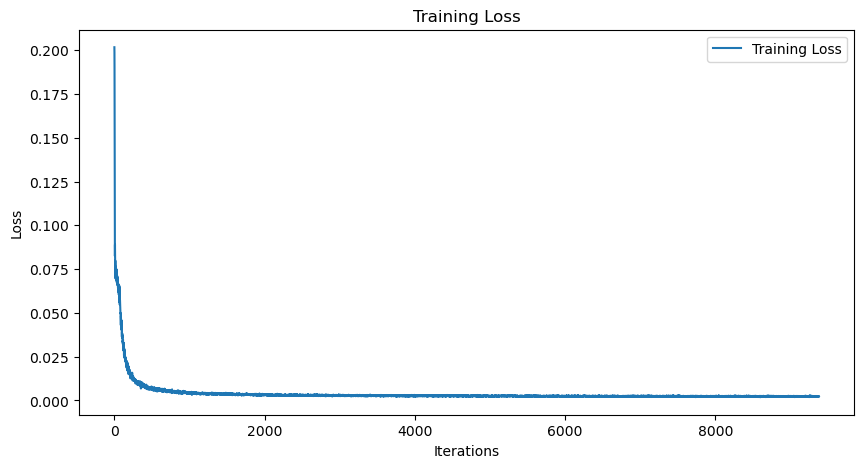

In [47]:
# Візуалізація графіка втрат
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Тренувальна втрата')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()